# Retrieval Augmented Generation (RAG) with LangChain 🦜🔗

Last update: 27.05.2025


<figure>
  <img src="./assets/agent_rag-with-langchain.png" width="800">
  <figcaption style="text-align: center; font-style: italic;">Querying Legal Documents with LangChain</figcaption>
</figure>

In [1]:
from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain import hub
from langchain.prompts import PromptTemplate
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as mticker
plt.style.use('dark_background')

from IPython.display import Image, display, HTML
from itertools import groupby

import warnings
from langsmith.utils import LangSmithMissingAPIKeyWarning
warnings.filterwarnings("ignore", category=LangSmithMissingAPIKeyWarning)

from dotenv import load_dotenv
load_dotenv()

True

This tutorial demonstrates how to query a legal document—a congressional bill titled [Wireless Electric Vehicle Charging Grant Program Act of 2025](https://www.congress.gov/bill/119th-congress/house-bill/1892/text), introduced on March 5, 2025. The bill spans 11 pages of detailed legislative text.

We leverage [Gemini 2.0 Flash](https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini/2-0-flash), a large language model (LLM) trained with data up to June 2024, so it cannot answer questions about this bill without directly analyzing the PDF.

To accomplish this, we load, split, embed, and store the PDF and then use similarity search to retrieve relevant sections and provide them to the LLM. We validate the model’s output with five targeted questions and verified answers from the bill.


In [2]:
questions = [
    "What is the maximum grant amount (in dollars) that an eligible entity can receive under the Wireless Electric Vehicle Charging Grant Program Act of 2025?",
    "What is the maximum Federal share percentage allowed for a grant under this Program?",
    "What total amount is authorized to be appropriated for the Program (in dollars)?",
    "According to the bill, what percentage of greenhouse gas emissions did the transportation sector account for as of 2019?",
    "Under the 'Buy America' requirement, which section of Title 49, United States Code, must grant recipients comply with?"
]

correct_answers = [
    '[SEC. 6. COST SHARE.]\n"(b) MAXIMUM GRANT AMOUNT.—The amount of a grant awarded to an eligible entity under the Program may not exceed $25,000,000." [p. 7]',
    '[SEC. 6. COST SHARE.]\n"(a) FEDERAL SHARE.—The Federal share of a grant awarded under the Program may not exceed 80 percent of total cost of the project." [p. 7]',
    '[SEC. 9. AUTHORIZATION OF APPROPRIATIONS.]\n"There is authorized to be appropriated $250,000,000 to carry out this Act, to remain available until expended." [p. 11]',
    '[SEC. 2. FINDINGS.]\n"Congress finds the following:\n(1) Electric vehicles are crucial to cutting greenhouse gas emissions, reducing reliance on fossil fuels, strengthening United States economic and national security, and combating the climate crisis. As of 2019, the transportation sector accounts for 29 percent of all greenhouse gas emissions, which is the most of any sector." [p. 2]',
    '[SEC. 7. PROGRAM REQUIREMENTS.]\n"(d) BUY AMERICA.—\n(1) IN GENERAL.—Except as provided in paragraph (2), recipients of grants under the Program shall comply with the requirements described in section 5323(j) of title 49, United States Code." [p. 10]'
]

ids = [f"Q{i+1}" for i in range(len(questions))]

df = pd.DataFrame({
    "ID": ids,
    "Question": questions,
    "Extract with Answer": correct_answers
}).set_index("ID")

def style_df(df):
    styled = df.style.set_table_styles([
        {'selector': 'table', 'props': [('border', '2px solid gray'), ('border-collapse', 'collapse')]},
        {'selector': 'th, td', 'props': [('border', '1px solid gray')]},
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'th.col0', 'props': [('width', '300px')]},  
        {'selector': 'th.col1', 'props': [('width', '300px')]},  
        {'selector': 'th.col2', 'props': [('width', '300px')]},  
        {'selector': 'td', 'props': [('text-align', 'left')]}
    ]).set_properties()
    return HTML(styled.to_html(escape=False))

display(style_df(df))


,Question,Extract with Answer
ID,,
Q1,What is the maximum grant amount (in dollars) that an eligible entity can receive under the Wireless Electric Vehicle Charging Grant Program Act of 2025?,"[SEC. 6. COST SHARE.] ""(b) MAXIMUM GRANT AMOUNT.—The amount of a grant awarded to an eligible entity under the Program may not exceed $25,000,000."" [p. 7]"
Q2,What is the maximum Federal share percentage allowed for a grant under this Program?,"[SEC. 6. COST SHARE.] ""(a) FEDERAL SHARE.—The Federal share of a grant awarded under the Program may not exceed 80 percent of total cost of the project."" [p. 7]"
Q3,What total amount is authorized to be appropriated for the Program (in dollars)?,"[SEC. 9. AUTHORIZATION OF APPROPRIATIONS.] ""There is authorized to be appropriated $250,000,000 to carry out this Act, to remain available until expended."" [p. 11]"
Q4,"According to the bill, what percentage of greenhouse gas emissions did the transportation sector account for as of 2019?","[SEC. 2. FINDINGS.] ""Congress finds the following: (1) Electric vehicles are crucial to cutting greenhouse gas emissions, reducing reliance on fossil fuels, strengthening United States economic and national security, and combating the climate crisis. As of 2019, the transportation sector accounts for 29 percent of all greenhouse gas emissions, which is the most of any sector."" [p. 2]"
Q5,"Under the 'Buy America' requirement, which section of Title 49, United States Code, must grant recipients comply with?","[SEC. 7. PROGRAM REQUIREMENTS.] ""(d) BUY AMERICA.— (1) IN GENERAL.—Except as provided in paragraph (2), recipients of grants under the Program shall comply with the requirements described in section 5323(j) of title 49, United States Code."" [p. 10]"


Next, we will pass the PDF text through the preprocessing pipeline: load, split, embed, and store. The figure below illustrates this preprocessing flow and maps the correct answers (A1–A5) to their corresponding pages and splits.

<figure>
  <img src="./assets/agent_rag-preprocessing-pipeline.png" width="800">
  <figcaption style="text-align: center; font-style: italic;">The RAG Preprocessing Pipeline</figcaption>
</figure>


## Load

LangChain’s `Document` is a data structure for handling text chunks. It typically represents a portion of a larger document and includes the following attributes:

- `id`: optional unique identifier
- `metadata`: a dictionary with source info or context
- `page_content`: the text content itself (required)
- `type`: new addition for the document type, e.g. Document or TextChunk


LangChain supports various [PDF loaders](https://python.langchain.com/docs/integrations/document_loaders/#pdfs), ranging from basic text extractors to advanced tools with OCR and layout analysis, allowing users to choose based on their specific needs:

- `PyPDFLoader`: best all-around for academic or structured PDFs. Great for research papers, reports, and text-based documents.
- `Unstructured`: best for scanned PDFs (with OCR support). Great for invoices, scanned forms, mixed-content files.
- `MathPix`: extracts math formulas, LaTeX, and figures well. Ideal for scientific articles, research papers with math.
- `PDFPlumber`: strong at extracting tables and structured data. Use when you care about exact layout or tabular info.

[PyPDFLoader](https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/) reads text from PDFs and returns one Document per page, with the text in `page_content`. When creating Document objects, PyPDFLoader typically tries to extract the human-readable `page_label` if it exists; otherwise, it falls back to a 1-based page number (i.e., index + 1).

In [3]:
file_path = "./data/input/BILLS-119hr1892ih.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(f"Total pages: {len(docs)}")
print(f"Document keys: {docs[0].model_dump().keys()}") 
print(f"Current page: {docs[0].metadata['page_label']}") 
print(f"Total characters on page {docs[0].metadata['page_label']}: {len(docs[0].page_content)}")
print(f"First 280 characters {docs[0].page_content[:280]}")


Total pages: 11
Document keys: dict_keys(['id', 'metadata', 'page_content', 'type'])
Current page: 1
Total characters on page 1: 1221
First 280 characters I 
119TH CONGRESS 
1ST SESSION H. R. 1892 
To direct the Secretary of Transportation to establish a Wireless Electric 
Vehicle Charging Grant Program, and for other purposes. 
IN THE HOUSE OF REPRESENTATIVES 
MARCH 5, 2025 
Ms. S TEVENS (for herself, Ms. B ARRAGA´N, Mrs. D INGELL


## Split

To improve retrieval and question answering, PDF pages can be split into smaller chunks using text splitters. LangChain recommends using `RecursiveCharacterTextSplitter` to divide text into chunks with overlap, preserving context. 


In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1_000, 
    chunk_overlap=200,
    separators=[r"(?=SEC\.)"],
    # separators=[r"(?=SEC\.)", "\n\n", "\n", ".", " "], # add fallbacks to stay within chunk_size
    is_separator_regex=True
)
all_splits = text_splitter.split_documents(docs)

print(f"Split the pdf into {len(all_splits)} sub-documents.")

Split the pdf into 16 sub-documents.


In [5]:
for page_label, group in groupby(sorted(all_splits, key=lambda x: x.metadata['page_label']), key=lambda x: x.metadata['page_label']):
    for split_order, split in enumerate(group, 1):
        split.metadata['split_order'] = split_order

print(all_splits[0].model_dump())

{'id': None, 'metadata': {'producer': 'Acrobat Distiller 24.0 (Windows); modified using iText® Core 7.2.3 (production version) ©2000-2022 iText Group NV, Government Publishing Office', 'creator': 'U.S. Gov. Printing Office -- G.S.D.D.', 'creationdate': '2025-03-19T21:00:42-04:00', 'moddate': '2025-03-20T02:50:22+00:00', 'title': '', 'source': './data/input/BILLS-119hr1892ih.pdf', 'total_pages': 11, 'page': 0, 'page_label': '1', 'split_order': 1}, 'page_content': 'I \n119TH CONGRESS \n1ST SESSION H. R. 1892 \nTo direct the Secretary of Transportation to establish a Wireless Electric \nVehicle Charging Grant Program, and for other purposes. \nIN THE HOUSE OF REPRESENTATIVES \nMARCH 5, 2025 \nMs. S TEVENS (for herself, Ms. B ARRAGA´N, Mrs. D INGELL, and Ms. T ITUS) \nintroduced the following bill; which was referred to the Committee on En-\nergy and Commerce, and in addition to the Committee on Transportation \nand Infrastructure, for a period to be subsequently determined by the \nSpeake

In [6]:
# Examine the result of splitting
for i in range(len(all_splits)):
    print(f"----------- Split {i+1} --------------")
    print(f"...........  Page {all_splits[i].metadata['page_label']} ..............")
    print(all_splits[i].page_content)


----------- Split 1 --------------
...........  Page 1 ..............
I 
119TH CONGRESS 
1ST SESSION H. R. 1892 
To direct the Secretary of Transportation to establish a Wireless Electric 
Vehicle Charging Grant Program, and for other purposes. 
IN THE HOUSE OF REPRESENTATIVES 
MARCH 5, 2025 
Ms. S TEVENS (for herself, Ms. B ARRAGA´N, Mrs. D INGELL, and Ms. T ITUS) 
introduced the following bill; which was referred to the Committee on En-
ergy and Commerce, and in addition to the Committee on Transportation 
and Infrastructure, for a period to be subsequently determined by the 
Speaker, in each case for consideration of such provisions as fall within 
the jurisdiction of the committee concerned 
A BILL 
To direct the Secretary of Transportation to establish a 
Wireless Electric Vehicle Charging Grant Program, and 
for other purposes. 
Be it enacted by the Senate and House of Representa-1
tives of the United States of America in Congress assembled, 2
SECTION 1. SHORT TITLE. 3
This Act m

In [7]:
split_info = []

for i, split in enumerate(all_splits, 1):
    # Get page number from metadata, if available
    page = split.metadata.get("page_label", "Unknown")
    # Get length of split in characters
    length = len(split.page_content)
    split_info.append({
        "Split": i,
        "Page_label": page,
        "Length (chars)": length
    })

import pandas as pd

df_splits = pd.DataFrame(split_info)
print(df_splits)
df_splits.to_csv("./data/output/split_results.csv", index=False)

    Split Page_label  Length (chars)
0       1          1            1020
1       2          1             201
2       3          2            1422
3       4          3            1334
4       5          4             667
5       6          4             657
6       7          5            1163
7       8          6              78
8       9          6            1256
9      10          7             462
10     11          7             807
11     12          8            1216
12     13          9            1299
13     14         10             943
14     15         10             189
15     16         11             821


In [8]:
df_splits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Split           16 non-null     int64 
 1   Page_label      16 non-null     object
 2   Length (chars)  16 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 516.0+ bytes


In [9]:
df_splits["Page_label"] = pd.to_numeric(df_splits["Page_label"], errors="coerce")
df_splits = df_splits.sort_values(by=["Page_label", "Split"])
df_splits["split_order"] = df_splits.groupby("Page_label").cumcount() + 1

correct_answer_splits = {3, 10, 14, 16}

pivot_lengths = df_splits.pivot(index="Page_label", columns="split_order", values="Length (chars)").fillna(0)
pivot_splits = df_splits.pivot(index="Page_label", columns="split_order", values="Split").fillna(0).astype(int)

def color_for_split(split_id):
    return "#ffbc00" if split_id in correct_answer_splits else "#52bcff"

colors_1 = [color_for_split(s) for s in pivot_splits[1]]
colors_2 = [color_for_split(s) for s in pivot_splits[2]]

# Load background image
bg_img = mpimg.imread('./assets/agent_pdf.png')

fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(
    pivot_lengths.index, pivot_lengths[1],
    color=colors_1,
    label="Split 1",
    edgecolor='white',
    alpha=0.8,
    zorder=2
)

bars2 = ax.bar(
    pivot_lengths.index, pivot_lengths[2],
    bottom=pivot_lengths[1],
    color=colors_2,
    label="Split 2",
    edgecolor='white',
    alpha=0.8,
    zorder=2
)

ax.imshow(
    bg_img,
    extent=[pivot_lengths.index.min() - 0.5, pivot_lengths.index.max() + 0.5, 0, 1500],
    aspect='auto', zorder=0
)
ax.axhspan(0, 1500, xmin=0, xmax=1, color='black', alpha=0.1, zorder=1)

for bar in bars1:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2,
            f"{int(height):,}",
            ha='center',
            va='center',
            fontsize=9,
            color='black'
        )

for bar1, bar2 in zip(bars1, bars2):
    height = bar2.get_height()
    if height > 0:
        bottom = bar1.get_height()
        ax.text(
            bar2.get_x() + bar2.get_width() / 2,
            bottom + height / 2,
            f"{int(height):,}",
            ha='center',
            va='center',
            fontsize=9,
            color='black'
        )

ax.set(xlabel="Page", ylabel="Number of Characters")
ax.set_title("Character Count per Split by Page")
ax.legend(
    handles=[
        plt.Line2D([0], [0], color="#52bcff", lw=8, label="w/o answer", markeredgecolor='white'),
        plt.Line2D([0], [0], color="#ffbc00", lw=8, label="with answer", markeredgecolor='white')
    ],
    title="Split Type", handlelength=1, frameon=False,
)

ax.set_xticks(pivot_lengths.index)
ax.set_xticklabels(pivot_lengths.index.astype(int))
ax.set_ylim(0, 1500)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.savefig("./data/output/split_page_chart.png", dpi=300)
plt.close()


<figure>
  <img src="./data/output/split_page_chart.png" width="800">
  <figcaption style="text-align: center; font-style: italic;">Visualization of the Split</figcaption>
</figure>

## Embed

LangChain supports [embeddings from many providers](https://python.langchain.com/docs/integrations/text_embedding/) like OpenAI, Google, Hugging Face, Llama, NVIDIA, and others.

In [10]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
print(embeddings.model)

vector = embeddings.embed_query("Hi!")
print("Vector length:", len(vector))
print(vector[:3])

models/embedding-001
Vector length: 768
[0.010295657441020012, -0.02703550085425377, -0.01325113233178854]


## Store

LangChain’s `VectorStore` lets you add and search text or documents using vector similarity. It works with embedding models to convert text into numeric vectors.

LangChain supports many vector stores—some are cloud-based (e.g. AstraDB), some run on local servers (e.g. Chroma), and others run **in-memory**, meaning they store data temporarily in your computer's RAM, ideal for quick tests or small workloads.

In [11]:
vector_store = InMemoryVectorStore(embeddings)
ids = vector_store.add_documents(documents=all_splits)
print(f"Number of IDs: {len(ids)}")
print(f"Sample IDs: {ids[0]}, {ids[3]}")

Number of IDs: 16
Sample IDs: d5302dc3-a191-459a-a254-7a4d4fd3c1f1, b1e637e3-3491-4f2d-b62f-44b66a65abff


In [12]:
print(dir(vector_store))
print(type(vector_store.store))
print(vector_store.store)
doc = vector_store.get_by_ids([ids[0]])
print(doc)


['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_asimilarity_search_with_relevance_scores', '_cosine_relevance_score_fn', '_euclidean_relevance_score_fn', '_get_retriever_tags', '_max_inner_product_relevance_score_fn', '_select_relevance_score_fn', '_similarity_search_with_relevance_scores', '_similarity_search_with_score_by_vector', 'aadd_documents', 'aadd_texts', 'add_documents', 'add_texts', 'adelete', 'afrom_documents', 'afrom_texts', 'aget_by_ids', 'amax_marginal_relevance_search', 'amax_marginal_relevance_search_by_vector', 'as_retriever', 'asearch', 'asimilarity_search', 'asimilarity_search_by_vector', '

## Retrieve

Once a `VectorStore` has documents, you can query it in various ways:
- by similarity or maximum marginal relevance (MMR),
- sync or async, 
- using text or vectors, 
- with or without similarity scores.


<figure>
  <img src="./assets/agent_langgraph-rag-pipeline.png" width="800">
  <figcaption style="text-align: center; font-style: italic;">The LangGraph RAG Pipeline</figcaption>
</figure>


In [ ]:
max_k = 10  # max number of results per question

data = {"Question": []}
for k in range(1, max_k + 1):
    data[f"k={k}"] = []

for question in questions:
    data["Question"].append(question)
    retrieved_docs = vector_store.similarity_search(question, k=max_k)
    
    for k in range(1, max_k + 1):
        if len(retrieved_docs) >= k:
            doc = retrieved_docs[k - 1]
            page = doc.metadata.get("page_label", "Unknown")
            split_order = doc.metadata.get("split_order", "Unknown")
            data[f"k={k}"].append(f"p={page}, s={split_order}")
        else:
            data[f"k={k}"].append("")

df_results = pd.DataFrame(data)
print(df_results)

                                            Question        k=1        k=2  \
0  What is the maximum grant amount (in dollars) ...   p=1, s=1   p=4, s=1   
1  What is the maximum Federal share percentage a...   p=7, s=1   p=6, s=2   
2  What total amount is authorized to be appropri...   p=6, s=2   p=7, s=1   
3  According to the bill, what percentage of gree...   p=2, s=1  p=11, s=1   
4  Under the 'Buy America' requirement, which sec...  p=10, s=1   p=7, s=2   

        k=3       k=4        k=5        k=6        k=7        k=8        k=9  \
0  p=7, s=2  p=4, s=2   p=5, s=1   p=6, s=2  p=11, s=1   p=7, s=1   p=3, s=1   
1  p=7, s=2  p=9, s=1   p=4, s=2  p=10, s=1   p=8, s=1   p=4, s=1   p=5, s=1   
2  p=7, s=2  p=4, s=2   p=4, s=1   p=5, s=1  p=11, s=1   p=1, s=2  p=10, s=1   
3  p=5, s=1  p=4, s=1  p=10, s=2   p=9, s=1   p=1, s=1   p=6, s=2   p=1, s=2   
4  p=6, s=2  p=8, s=1   p=9, s=1   p=4, s=2   p=7, s=1  p=10, s=2   p=1, s=2   

       k=10  
0  p=2, s=1  
1  p=1, s=1  
2  p=1, 

In [14]:
rag_prompt = hub.pull("rlm/rag-prompt")
print("-----\nRAG Prompt:\n", rag_prompt.messages[0].prompt.template)

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""You are a legal assistant. Answer the question using only the information provided in the context. Quote or copy the exact relevant text from the context, cleaning PDF extraction artifacts, such as line numbers, if necessary. If the answer is not present, reply "Not in context."
Question: {question}
Context: {context}
Answer:"""
)
print("-----\nCustom Prompt:\n", custom_prompt.template)



-----
RAG Prompt:
 You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
-----
Custom Prompt:
 You are a legal assistant. Answer the question using only the information provided in the context. Quote or copy the exact relevant text from the context, cleaning PDF extraction artifacts, such as line numbers, if necessary. If the answer is not present, reply "Not in context."
Question: {question}
Context: {context}
Answer:


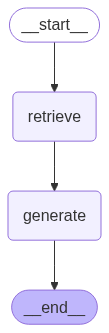

In [15]:
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=10)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png(
    background_color="transparent",
    output_file_path="./data/output/langgraph.png"
)))

In [16]:
result = graph.invoke({"question": """What is the maximum Federal share percentage 
                       allowed for a grant under the 
                       Wireless Electric Vehicle Charging Grant Program?"""})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='5ce32341-793c-42aa-a940-522607ad64e1', metadata={'producer': 'Acrobat Distiller 24.0 (Windows); modified using iText® Core 7.2.3 (production version) ©2000-2022 iText Group NV, Government Publishing Office', 'creator': 'U.S. Gov. Printing Office -- G.S.D.D.', 'creationdate': '2025-03-19T21:00:42-04:00', 'moddate': '2025-03-20T02:50:22+00:00', 'title': '', 'source': './data/input/BILLS-119hr1892ih.pdf', 'total_pages': 11, 'page': 6, 'page_label': '7', 'split_order': 2}, page_content='SEC. 7. PROGRAM REQUIREMENTS. 11\n(a) P RIORITY.—In awarding the grants under the 12\nProgram, the Secretary shall prioritize projects that— 13\n(1) focus on non-disruptive designs that are 14\ncompatible with existing infrastructure and bene-15\nficial to the public, including for low income, under-16\nserved, or disadvantaged communities; 17\n(2) focus on cost-effective, energy-efficient, and 18\nenvironmentally sustainable technologies for public 19\nuse; 20\n(3) focus on compatibi

In [17]:
answers = []
for question in questions:
    result = graph.invoke({"question": question})
    answers.append(result['answer'])

In [18]:
df['Model Answer'] = answers
display(style_df(df))

,Question,Extract with Answer,Model Answer
ID,,,
Q1,What is the maximum grant amount (in dollars) that an eligible entity can receive under the Wireless Electric Vehicle Charging Grant Program Act of 2025?,"[SEC. 6. COST SHARE.] ""(b) MAXIMUM GRANT AMOUNT.—The amount of a grant awarded to an eligible entity under the Program may not exceed $25,000,000."" [p. 7]","""The amount of a grant awarded to an eligible entity under the Program may not exceed $25,000,000."""
Q2,What is the maximum Federal share percentage allowed for a grant under this Program?,"[SEC. 6. COST SHARE.] ""(a) FEDERAL SHARE.—The Federal share of a grant awarded under the Program may not exceed 80 percent of total cost of the project."" [p. 7]","""The Federal share of a grant awarded under the Program may not exceed 80 percent of total cost of the project."""
Q3,What total amount is authorized to be appropriated for the Program (in dollars)?,"[SEC. 9. AUTHORIZATION OF APPROPRIATIONS.] ""There is authorized to be appropriated $250,000,000 to carry out this Act, to remain available until expended."" [p. 11]","""There is authorized to be appropriated $250,000,000 to carry out this Act, to remain available until expended."""
Q4,"According to the bill, what percentage of greenhouse gas emissions did the transportation sector account for as of 2019?","[SEC. 2. FINDINGS.] ""Congress finds the following: (1) Electric vehicles are crucial to cutting greenhouse gas emissions, reducing reliance on fossil fuels, strengthening United States economic and national security, and combating the climate crisis. As of 2019, the transportation sector accounts for 29 percent of all greenhouse gas emissions, which is the most of any sector."" [p. 2]","""As of 2019, the transportation sector accounts for 29 percent of all greenhouse gas emissions, which is the most of any sector."""
Q5,"Under the 'Buy America' requirement, which section of Title 49, United States Code, must grant recipients comply with?","[SEC. 7. PROGRAM REQUIREMENTS.] ""(d) BUY AMERICA.— (1) IN GENERAL.—Except as provided in paragraph (2), recipients of grants under the Program shall comply with the requirements described in section 5323(j) of title 49, United States Code."" [p. 10]","""recipients of grants under the Program shall comply with the requirements described in section 5323(j) of title 49, United States Code."""


# References

- LangChain. Build a Retrieval Augmented Generation (RAG) App: Part 1. https://python.langchain.com/docs/tutorials/rag/
- LangChain. Build a semantic search engine. https://python.langchain.com/docs/tutorials/retrievers/

